# 【課題】位相推定によるスペクトル分解

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{|#1\rangle}$

## エネルギースペクトルを求める

{doc}`後の実習 <vqe>`にも現れるように、物理学や化学において、系のエネルギー固有値（スペクトル）と対応する固有状態を求めるということは非常に重要な問題です。系のエネルギースペクトルを求めることとは、系を表すハミルトニアンを決め、それを対角化することに対応します。

しかし、{doc}`前回の実習 <dynamics_simulation>`でも出てきたように、一般的に量子系の次元数は莫大で、ハミルトニアンの対角化の肝となる逆行列の計算をまともに行うことはできません。同実習では、そのような場合でも、ハミルトニアンが効率的な鈴木・トロッター分解を許す形であれば、量子コンピュータを使って時間発展シミュレーションを行えるということを示しました。ただし、このシミュレーションでは、系のエネルギー固有値や固有状態を明示的に利用しませんでした。

実は、同じ時間発展シミュレーションの手法と、{doc}`shor`で登場した位相推定の手法を組み合わせると、エネルギー固有値も数値的に求めることができます{cite}`Aspuru-Guzik1704`。さらに、工夫によっては対応する固有状態も調べられます。ここでは外部磁場のかかったハイゼンベルグモデルを題材に、位相推定によるエネルギースペクトル分解をしてみましょう。

## ハイゼンベルグモデル再考

前回登場したハイゼンベルグモデルのハミルトニアンは

$$
H = -J \sum_{j=0}^{n-2} (\sigma^X_{j+1}\sigma^X_{j} + \sigma^Y_{j+1}\sigma^Y_{j} + \sigma^Z_{j+1} \sigma^Z_{j}) \quad (J > 0)
$$

というものでした。このハミルトニアンが表しているのは、空間中で一列に並んだスピンを持つ粒子が、隣接粒子間で相互作用を及ぼしているような系でした。ここで相互作用は、スピンの向きが揃っているときにエネルギーが低くなるようなものでした。したがって、全てののスピンが同じ方向を向いているときにエネルギーが最も低くなることが予想されました。

今回は、このハミルトニアンに外部からの磁場の影響を入れます。外部磁場がある時は、スピンが磁場の方向を向いているときにエネルギーが低くなります。したがって、外部磁場を$+Z$方向にかけるとすれば、ハミルトニアンは

$$
H = -J \sum_{j=0}^{n-1} (\sigma^X_{j+1}\sigma^X_{j} + \sigma^Y_{j+1}\sigma^Y_{j} + \sigma^Z_{j+1} \sigma^Z_{j} + g \sigma^Z_j)
$$

となります。このハミルトニアンにはもう一点前回と異なる部分があります。前回はスピンに関する和を$j=0$から$n-2$まで取ることで、両端のスピンは「内側」のスピンとしか相互作用をしないような境界条件を採用していました。今回は和を$n-1$まで取っています。$\sigma^{X,Y,Z}_n$を$\sigma^{X,Y,Z}_0$と同一視することで、これは「周期境界条件」（一列ではなく環状に並んだスピン）を表します。

このようなハミルトニアンの固有値や固有状態がどのような値を取るのか、具体例で確認しましょう。最も簡単な$n=2, g=0$というケースを考え、直接対角化して厳密解を求めます。

In [1]:
# まず必要なモジュールをインポートする
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
# ワークブック独自のモジュール
from qc_workbook.show_state import show_state

print('notebook ready')

notebook ready


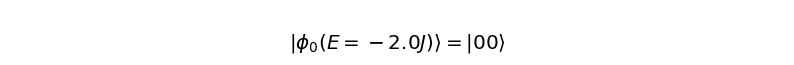

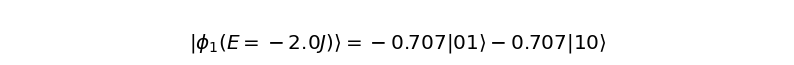

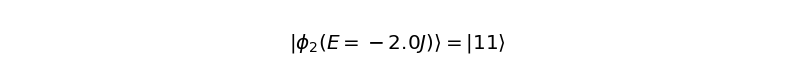

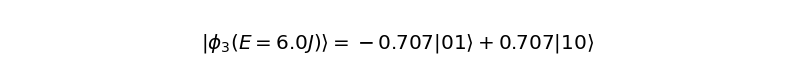

In [2]:
# Number of spins
n_s = 2
# Coupling parameter
J = 1.
# External field / J
g = 0.

# Construct the Hamiltonian matrix
paulis = list()
coeffs = list()

xx_template = 'I' * (n_s - 2) + 'XX'
yy_template = 'I' * (n_s - 2) + 'YY'
zz_template = 'I' * (n_s - 2) + 'ZZ'

for j in range(n_s):
    paulis.append(xx_template[j:] + xx_template[:j])
    paulis.append(yy_template[j:] + yy_template[:j])
    paulis.append(zz_template[j:] + zz_template[:j])
    coeffs += [-J] * 3

    if g != 0.:
        paulis.append('I' * (n_s - j - 1) + 'Z' + 'I' * j)
        coeffs.append(-J * g)

hamiltonian = SparsePauliOp(paulis, coeffs).to_matrix()

# Diagonalize and obtain the eigenvalues and vectors
eigvals, eigvectors = np.linalg.eigh(hamiltonian)

# Print the eigenvectors
for i in range(eigvals.shape[0]):
    show_state(eigvectors[:, i], binary=True, state_label=r'\phi_{} (E={}J)'.format(i, eigvals[i]))

最後の部分で、[`show_state`関数](https://github.com/UTokyo-ICEPP/qc-workbook/tree/master/source/qc_workbook/show_state.py)を利用して固有値と固有ベクトルを表示しました。最低エネルギー状態（固有値$-2J$）に対応する独立な固有ベクトルが3つあることがわかります。したがって、これらの固有ベクトルの任意の線形和もまた最低エネルギー状態です。励起状態（固有値$6J$）は$1/\sqrt{2} (-\ket{01} + \ket{10})$です。

## 位相推定によるスペクトル分解

それでは本題に入りましょう。{doc}`shor`で登場した下の図において、$U$が何らかのハミルトニアン$H$による適当な時間$\tau$の時間発展演算子$U_H(-\tau)$である場合、何が言えるでしょうか。

```{image} figs/qpe_wo_iqft.png
:alt: qpe_wo_iqft
:width: 500px
:align: center
```

以下では、図中上のレジスタ（初期状態$\ket{0}$）を読み出し(readout)レジスタR、下のレジスタ（初期状態$\ket{\psi}$）を状態(state)レジスタSと呼びます。RとSのビット数をそれぞれ$n_R$, $n_S$とします。また、図では読み出しレジスタの最低位（1の位）に対応するビットが一番下に描かれており、Qiskitでの描画法と逆になっていることに注意してください。

さて、ハミルトニアン$H$を、エネルギーの次元を持つ定数$\hbar \omega$と無次元のエルミート演算子$\Theta$とに分解します。

$$
H = \hbar \omega \Theta.
$$

ここで$\omega$はどう選んでも構いません。$\omega$を$x$倍大きく取れば、その分$\Theta$に$1/x$の係数をかけるだけです。実際には、後述するように$\Theta$の固有値の絶対値が1より少しだけ小さくなるように$\omega$を決めます。この書き換えにより

$$
U_H(-\tau) \ket{\psi} = \exp\left(i\omega \tau \Theta\right) \ket{\psi}
$$

なので、図の回路に対応する演算子を$\Gamma$とおくと、

$$
\Gamma \ket{0}_R \ket{\psi}_S = \frac{1}{\sqrt{2^{n_R}}} \sum_{j=0}^{2^{n_R} - 1} \exp\left(i j \omega \tau \Theta\right) \ket{j}_R \ket{\psi}_S
$$

です。この状態に対して、実習と同じように逆フーリエ変換を施します。

$$
\text{QFT}^{\dagger}_R \Gamma \ket{0}_R \ket{\psi}_S = \frac{1}{2^{n_R}} \sum_{k=0}^{2^{n_R} - 1} \sum_{j=0}^{2^{n_R} - 1} \exp(i j \omega \tau \Theta) \exp\left(-\frac{2 \pi i j k}{2^{n_R}}\right) \ket{k}_R \ket{\psi}_S.
$$

さて、ここまで$\tau$は「適当な時間」としか決めて来ませんでしたが、実際にどんな値をとってもいいので、$\omega \tau = 2 \pi$となるように決めてしまいましょう。すると

$$
\text{QFT}^{\dagger}_R \Gamma \ket{0}_R \ket{\psi}_S = \frac{1}{2^{n_R}} \sum_{k=0}^{2^{n_R} - 1} \sum_{j=0}^{2^{n_R} - 1} \exp\left[\frac{2 \pi i j}{2^{n_R}} \left(2^{n_R} \Theta - k\right)\right] \ket{k}_R \ket{\psi}_S
$$

となります。したがって、$\Theta$の固有ベクトル$\{\ket{\phi_m}\}$で$\ket{\psi}$が

```{math}
:label: spectral_decomposition
\ket{\psi} = \sum_{m=0}^{2^{n_S} - 1} \psi_m \ket{\phi_m}
```

と書けるなら、対応する固有値を$\{\theta_m\}$とし、$\kappa_m = 2^{n_R} \theta_m$を用いて

```{math}
:label: spectrum_estimation_final
\begin{align}
\text{QFT}^{\dagger}_R \Gamma \ket{0}_R \ket{\psi}_S & = \frac{1}{2^{n_R}} \sum_{k=0}^{2^{n_R} - 1} \sum_{j=0}^{2^{n_R} - 1} \sum_{m=0}^{2^{n_S} - 1} \psi_m \exp\left[\frac{2 \pi i j}{2^{n_R}} (\kappa_m - k)\right] \ket{k}_R \ket{\phi_m}_S \\
& = \sum_{k=0}^{2^{n_R} - 1} \sum_{m=0}^{2^{n_S} - 1} \psi_m f(\kappa_m - k) \ket{k}_R \ket{\phi_m}_S.
\end{align}
```

ただし、二つめの等号で、$f(\kappa_m - k) := \frac{1}{2^{n_R}} \sum_{j} \exp \left[2 \pi i j (\kappa_m - k) / 2^{n_R}\right]$と定義しました。

最後にこの状態を測定し、Rに現れるビット列から推定される$\theta_m = 2^{-n_R} \kappa_m$に$\hbar \omega$をかければ、$H$のエネルギー固有値がわかります。

なんだか掴みどころのない$\omega$や$\tau$といったパラメータが登場して、結局何をしたのか分かりにくいという方のために、別の見方で問題を整理しましょう。結局上で行ったことは、ハミルトニアン$H$を与えられたときに、

1. 固有値が$\lesssim 1$（負の値があり得る場合は、その絶対値が$\lesssim \frac{1}{2}$）になるように$H$を規格化する（規格化の定数は記録しておく）
1. 規格化した結果の演算子を$\Theta$として、$U = \exp(-2 \pi i \Theta)$の位相推定をする
1. 位相推定から得られた$\Theta$の固有値に、1.の規格化定数をかけてエネルギー固有値を得る

という操作でした。ここで、$\Theta$の固有値を上のように決めるのは、読み出しレジスタに現れる固有値の数値が{ref}`オーバーフロー <signed_binary>`を起こさないようにするためです。

固有値を求める問題なのに固有値が具体的な値になるように規格化定数を選ぶというのは一見矛盾しているように聞こえます。しかし、{doc}`dynamics_simulation`で触れたように、量子コンピューティングで表現されるハミルトニアンは全て基底演算子${I, \sigma^X, \sigma^Y, \sigma^Z}$の積の線形和に分解できます。個々の基底演算子の積の固有値は$\pm 1$なので、ハミルトニアン$H$が基底演算子の積$\sigma_k$とエネルギー係数$h_k$で

$$
H = \sum_{k} h_k \sigma_k
$$

と分解できるとすれば、$H$の固有値の絶対値は最大で$\sum_{k} |h_k|$です。したがって、全く未知のハミルトニアンに対しても、まず規格化定数を$\hbar \omega = 2 \sum_{k} |h_k|$と取ればいいことがわかります。スペクトル推定の結果、最大固有値がもっと小さい値であれば、規格化定数を調節して再度計算を行えばいいだけです。

同じ理屈で読み出しレジスタRのビット数も決めることができます。今度は非ゼロで最も小さい固有値の絶対値を考えます。最小値は

$$
\mu = \min_{s_k = \pm 1} \left| \sum_{k} s_k h_k \right|
$$

以上です。この値を求めるには原理的には$2^{L}$（$L$はハミルトニアンの項数）通りの組み合わせを調べる必要がありますが、実際のハミルトニアンは通常そこまで複雑な形をしていないので、これも難しくないと考えられます。レジスタRのビット数$n_R$は$2^{n_R}\mu/(\hbar \omega)$が読みだせるように設定します。

これで規格化定数と読み出しレジスタの大きさが簡単に決められることがわかりましたが、問題は演算子$U$を作用させる対象の状態$\ket{\psi}$です。第$m$準位のエネルギー固有値を知りたい場合、式{eq}`spectral_decomposition`で$\psi_m \neq 0$でなければいけません。特殊なケースではスペクトル推定の前から固有ベクトルの「当たり」がついていることがあるかもしれませんが、当然、一般のハミルトニアンに対して、任意の$m$についてそのような状態を準備することはできません。

一方、系の最低エネルギー$\hbar \omega \theta_0$なら、{doc}`vqe`の手法などを用いて最低エネルギー状態の近似を実現し、それをSの初期状態とすることで、比較的に安定して求めることは可能です。そのため、上の手法は原理的にはスペクトルの完全な分解に使えますが、実際には最低エネルギーとその固有ベクトルを正確に求めるために利用することが多いと考えられます。

## 問題1: スペクトル推定を実装し、厳密解と照らし合わせる

それでは、位相推定を利用してハイゼンベルグモデルのハミルトニアンのスペクトルを求めてみましょう。

$U_H(-\tau)$を量子コンピュータ上で計算するために、鈴木・トロッター分解を使います。$ZZ, XX, YY$回転ゲートの実装法は{doc}`dynamics_simulation`を参照してください。

次のセルでは$U_H(-2\pi/\omega)$を鈴木・トロッター分解した量子回路を返す関数を定義しています。引数`num_steps`で分解の細かさを指定できます。

In [3]:
def trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps):
    """Return a function that implements a single Trotter step for the Heisenberg model.

    The Heisenberg model Hamiltonian is
    H = -J * sum_of_sigmas = hbar*ω * Θ

    The returned circuit implements a negative time evolution
    U = exp(-i H*(-τ)/hbar)
    where τ = 2π / ω, which leads to
    U = exp(i 2π Θ).

    Because we employ the Suzuki-Trotter decomposition, the actual circuit corresponds to
    U = [exp(i 2π/num_steps Θ)]^num_steps.

    Args:
        state_register (QuantumRegister): Register to perform the Suzuki-Trotter simulation.
        energy_norm (float): J/(hbar*ω).
        g (float): External field strength relative to the coupling constant J.
        num_steps (float): Number of steps to divide the time evolution of ωτ=2π.

    Returns:
        QuantumCircuit: A quantum circuit implementing the Trotter simulation of the Heisenberg
        model.
    """
    circuit = QuantumCircuit(state_register, name='ΔU')

    n_spins = state_register.size
    step_size = 2. * np.pi / num_steps

    # Implement the circuit corresponding to exp(i*step_size*Θ) below, where Θ is defined by
    # Θ = -J/(hbar*ω) * sum_of_sigmas = -energy_norm * sum_of_sigmas
    ##################
    ### EDIT BELOW ###
    ##################

    # circuit.?

    ##################
    ### EDIT ABOVE ###
    ##################

    circuit = circuit.repeat(num_steps)
    circuit.name = 'U'

    return circuit

次のセルでスペクトル推定のアルゴリズムを実装しています。この関数は状態レジスタ、読み出しレジスタ、時間発展回路を引数に取り、スペクトル推定の量子回路を返します。

In [4]:
def spectrum_estimation(state_register, readout_register, u_circuit):
    """Perform a spectrum estimation given a circuit containing state and readout registers and a callable implementing
    a single Trotter step.

    Args:
        state_register (QuantumRegister): State register.
        readout_register (QuantumRegister): Readout register.
        u_circuit (QuantumCircuit): A circuit implementing U_H(-2π/ω).

    Returns:
        QuantumCircuit: A circuit implementing the spectrum estimation of the given Hamiltonian.
    """
    circuit = QuantumCircuit(state_register, readout_register, name='Spectrum estimation')

    # Set the R register to an equal superposition
    circuit.h(readout_register)

    # Apply controlled-U operations to the circuit
    for iq, qubit in enumerate(readout_register):
        # Repeat the 2π evolution by 2^iq and convert it to a controlled gate
        controlled_u_gate = u_circuit.repeat(2 ** iq).to_gate().control(1)

        # Append the controlled gate specifying the control and target qubits
        circuit.append(controlled_u_gate, qargs=([qubit] + state_register[:]))

    circuit.barrier()

    # Inverse QFT
    for iq in range(readout_register.size // 2):
        circuit.swap(readout_register[iq], readout_register[-1 - iq])

    dphi = 2. * np.pi / (2 ** readout_register.size)

    for jtarg in range(readout_register.size):
        for jctrl in range(jtarg):
            power = jctrl - jtarg - 1 + readout_register.size
            circuit.cp(-dphi * (2 ** power), readout_register[jctrl], readout_register[jtarg])

        circuit.h(readout_register[jtarg])

    return circuit

この問題では、上で厳密解を求めた$n=2, g=0$のケースを調べます。今回はすでにエネルギー固有値を知っているので、ハミルトニアンの規格化定数を$\hbar \omega = 16J$として、読み出しレジスタの終状態が単純になるようにします。このとき読み出しは符号付きで、最大絶対値が$2^{n_R} (6/16)$なので、$n_R = 1 + 3$とすればオーバーフローを回避できます。

次のセルでシミュレーションとスペクトル推定のパラメータを設定します。

In [5]:
## Physics model parameter
g = 0.

## Spectrum estimation parameters
# Hamiltonian normalization
energy_norm = 1. / 16. # J/(hbar*ω)
# Number of steps per 2pi evolution
# Tune this parameter to find the best balance of simulation accuracy versus circuit depth
num_steps = 6
# Register sizes
n_state = 2
n_readout = 4

## Registers
state_register = QuantumRegister(n_state, 'state')
readout_register = QuantumRegister(n_readout, 'readout')

上で正しく関数をかけているか確認しておきましょう。

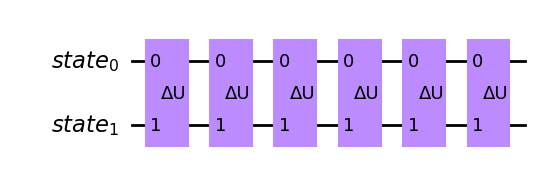

In [6]:
u_circuit = trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps)
u_circuit.draw('mpl')

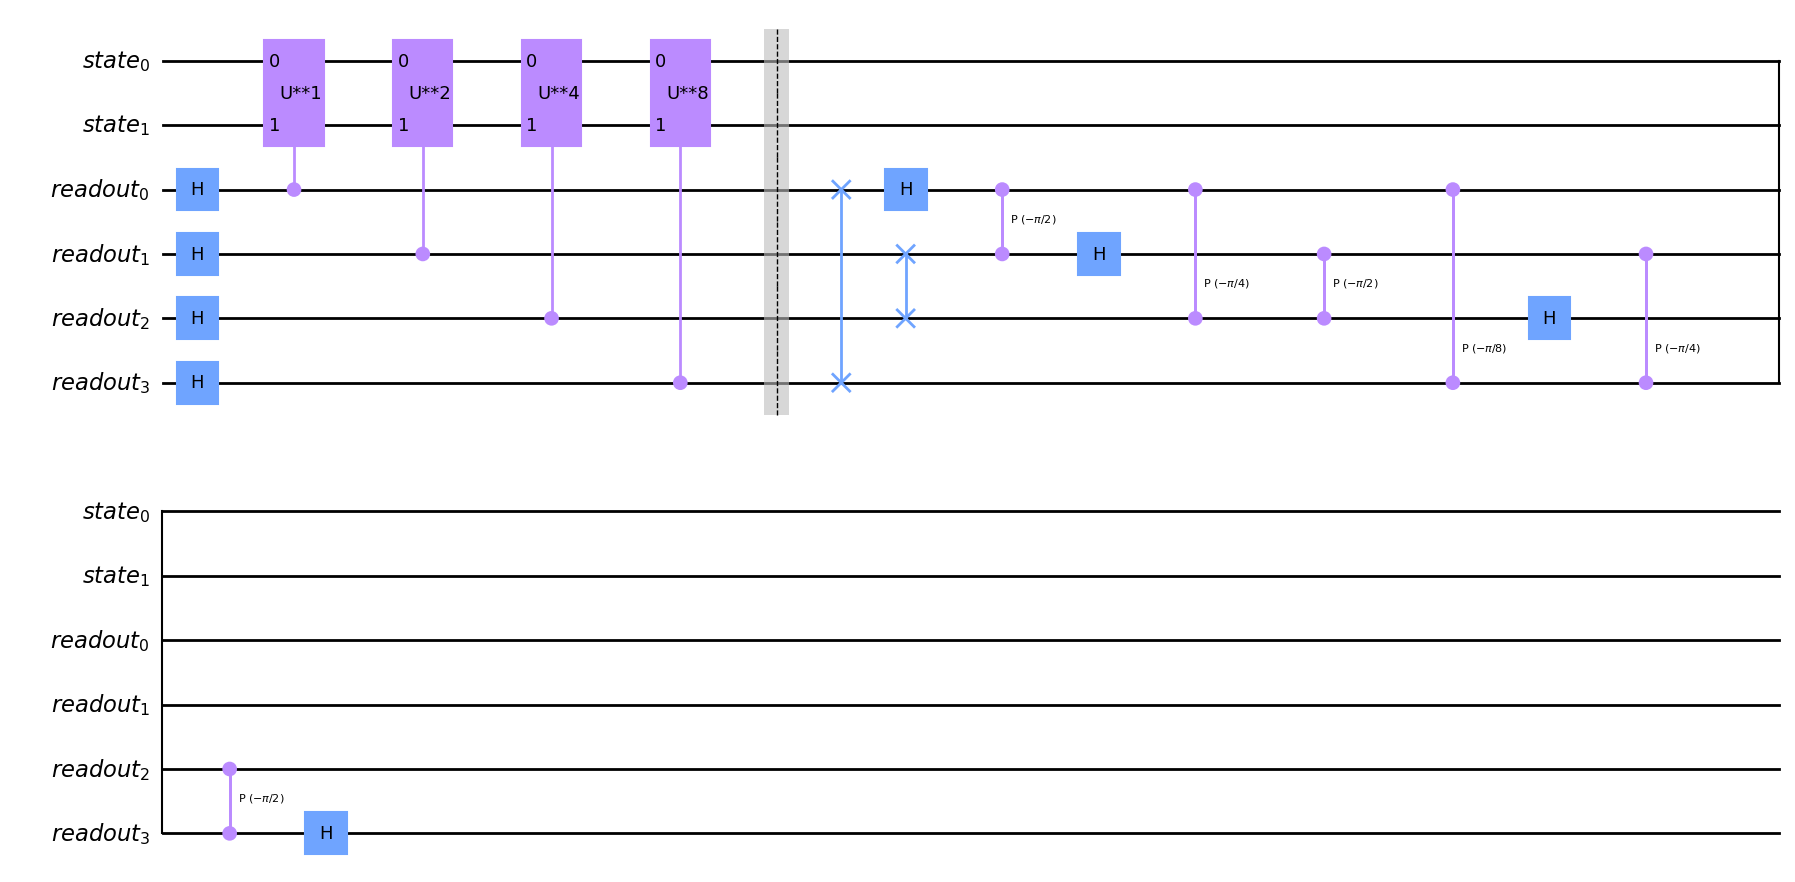

In [7]:
se_circuit = spectrum_estimation(state_register, readout_register, u_circuit)
se_circuit.draw('mpl')

状態レジスタの初期状態を

```{math}
:label: two_qubit_init
\frac{1}{2}\ket{00} - \frac{1}{\sqrt{2}}\ket{01} + \frac{1}{2} \ket{11} = \frac{1}{2} \ket{\phi_0} + \frac{1}{2} \ket{\phi_1} + \frac{1}{2} \ket{\phi_2} + \frac{1}{2} \ket{\phi_3}
```

とする関数を書きます。ここで$\ket{\phi_i}$は最初に求めた固有ベクトルの4つの厳密解です。

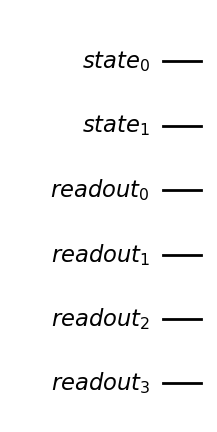

In [8]:
def make_initial_state(state_register, readout_register):
    circuit = QuantumCircuit(state_register, readout_register)

    # Set the initial state of the state vector to (1/2)|00> - (1/sqrt(2))|01> + (1/2)|11>
    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?

    ##################
    ### EDIT ABOVE ###
    ##################

    return circuit


init_circuit = make_initial_state(state_register, readout_register)
init_circuit.draw('mpl')

最後に全てを組み合わせます。

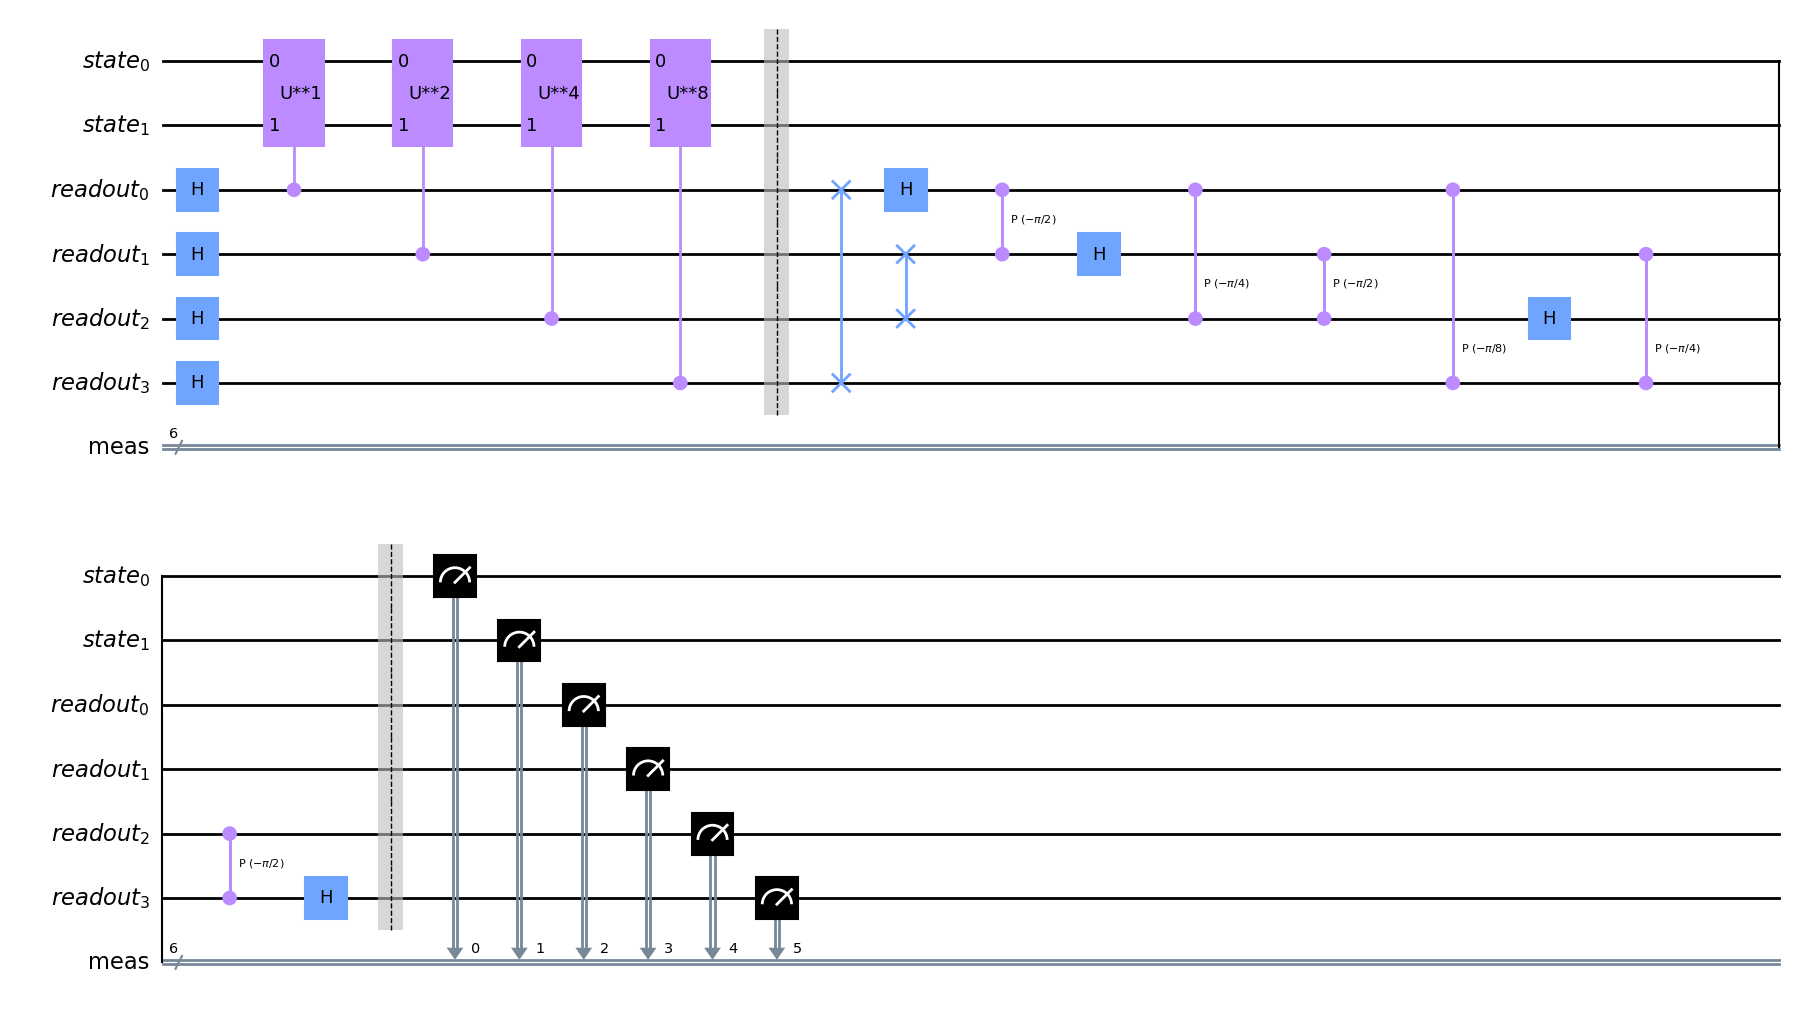

In [9]:
u_circuit = trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps)
se_circuit = spectrum_estimation(state_register, readout_register, u_circuit)

circuit = make_initial_state(state_register, readout_register)
circuit.compose(se_circuit, inplace=True)
circuit.measure_all()
circuit.draw('mpl')

シミュレータで実行してヒストグラムを得ます。

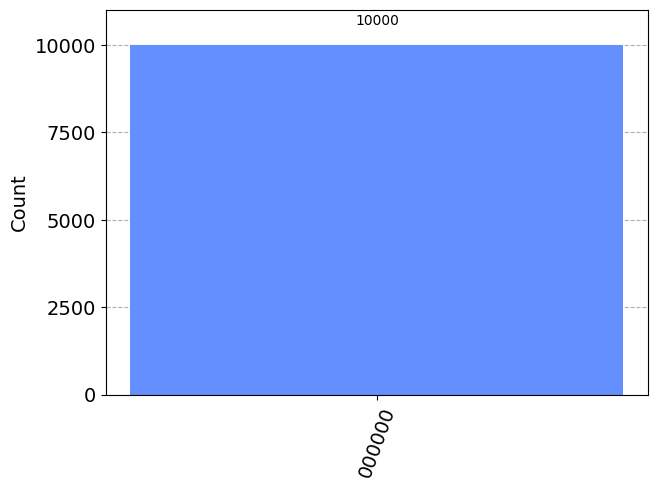

In [10]:
# Run the circuit in simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=10000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

状態レジスタの初期状態が式{eq}`two_qubit_init`なので、回路の終状態は

$$
\frac{1}{2} \ket{-2}_{R} \ket{00}_{S} - \frac{1}{2\sqrt{2}} \ket{-2}_{R} \left( \ket{01}_{S} + \ket{10}_{S} \right) + \frac{1}{2} \ket{-2}_{R} \ket{11}_{S} - \frac{1}{2\sqrt{2}} \ket{6}_{R} \left( \ket{01}_{S} - \ket{10}_{S} \right)
$$

となるはずです。得られたヒストグラムはこの状態と無矛盾でしょうか？

**提出するもの**

- 完成した`make_trotter_step_heisenberg`関数
- 完成した状態レジスタの初期化回路
- スペクトル推定の結果のヒストグラムと、その解釈

## 問題2: 非自明な系の振る舞いを調べる

今度は$n=4$のハイゼンベルグモデルで、全エネルギースペクトルを$g$の関数として求めてみましょう。$n=4$なので最初にやったような対角化もまだ簡単にできますが、ここではあえて量子計算のみに頼ってみます。

全てのエネルギー固有値を知るためにはSの初期状態を工夫しなければいけませんが、今回は事前の情報がないので、しらみつぶし戦略をとります。つまり、計算基底$\ket{0}$から$\ket{15}$までをそれぞれ初期状態としてスペクトル推定を繰り返し、得られる情報をつなぎ合わせて全体のスペクトルを求めます。

全ての計算基底についてスペクトル推定をすると、どんな情報が得られるでしょうか。式{eq}`spectrum_estimation_final`で$\ket{\psi} = \ket{l}$ $(l=0,\dots,2^{n_S} - 1)$とおき、

```{math}
:label: phim_decomposition
\ket{l} = \sum_{m=0}^{2^{n_S} - 1} c^l_m \ket{\phi_m}
```

とします。すると回路の終状態は

$$
\sum_{k=0}^{2^{n_R} - 1} \sum_{m=0}^{2^{n_S} - 1} c^l_m f(\kappa_m - k) \ket{k}_R \ket{\phi_m}_S
$$

となります。実は式{eq}`phim_decomposition`が成り立つとき

```{math}
:label: l_decomposition
\ket{\phi_m} = \sum_{l=0}^{2^{n_S} - 1} c^{l*}_m \ket{l}
```

も成り立つ[^unitarity]ので、終状態の回路をRとSの計算基底で測定し、$k, h$を得る確率を$P_l(k, h)$とすると

$$
P_l(k, h) = \left| \sum_{m=0}^{2^{n_S} - 1} c^l_m c^{h*}_m f(\kappa_m - k) \right|^2
$$

となります。$c^l_m$の値がわからなくても、これらの分布から

$$
P(k) = \frac{1}{2^{n_S}} \sum_{m=0}^{2^{n_S} - 1} |f(\kappa_m - k)|^2
$$

を得る方法を考えてみてください。

$|f(\kappa_m - k)|$は$\kappa_m$近傍で鋭いピークを持つ分布なので、$P(k)$を$k$に対してプロットすれば、$m$個の（部分的に重なり合っている可能性のある）ピークが見られ、そこからエネルギー固有値が算出できます。

試しに$n=2, g=0, \hbar \omega = 20J, n_R=4$で$P(k)$をプロットすると以下のようになります（問題1と異なり$\hbar \omega = 20J$なので、$\kappa_m$が整数ではありません）。ただし、負の固有値がわかりやすいように、$P(k - 2^{n_R}) = P(k)$として、$-2^{n_R - 1} \leq k < 2^{n_R - 1}$の範囲を表示しています。

```{image} figs/spectrum_estimation_example.png
:alt: spectrum_estimation_example
:width: 500px
:align: center
```

このようなプロットを$n=4$で$g$の値を0から0.5まで0.1刻みに変えながら作ってみましょう。

まずは計算基底と$g$の値を引数に取り、終状態の確率分布を返す関数を定義します。通常のショットベースのシミュレータでは統計誤差の影響が乗るので、デフォルトでは状態ベクトルシミュレーションを使うことにします。

[^unitarity]: これは$\{\ket{l}\}$と$\{\ket{\phi_m}\}$がともに状態レジスタの正規直交基底を張る（変換行列がユニタリである）ことに起因します。

In [11]:
def get_spectrum_for_comp_basis(
    n_state: int,
    n_readout: int,
    l: int,
    energy_norm: float,
    g: float,
    shots: int = 0
) -> np.ndarray:
    """Compute and return the distribution P_l(k, h) as an ndarray.

    Args:
        n_state: Size of the state register.
        n_readout: Size of the readout register.
        l: Index of the initial-state computational basis in the state register.
        energy_norm: Hamiltonian normalization.
        g: Parameter g of the Heisenberg model.
        shots: Number of shots. If <= 0, statevector simulation will be used.
    """

    # Define the circuit
    state_register = QuantumRegister(n_state, 'state')
    readout_register = QuantumRegister(n_readout, 'readout')
    circuit = QuantumCircuit(state_register, readout_register)

    # Initialize the state register
    for iq in range(n_state):
        if ((l >> iq) & 1) == 1:
            circuit.x(state_register[iq])

    u_circuit = trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps)
    se_circuit = spectrum_estimation(state_register, readout_register, u_circuit)

    circuit.compose(se_circuit, inplace=True)

    # Extract the probability distribution as an array of shape (2 ** n_readout, 2 ** n_state)
    if shots <= 0:
        circuit.save_statevector()

        simulator = AerSimulator(method='statevector')
        circuit = transpile(circuit, backend=simulator)
        job = simulator.run(circuit)
        result = job.result()
        statevector = result.data()['statevector']

        # Convert the state vector into a probability distribution by taking the norm-squared
        probs = np.square(np.abs(statevector)).reshape((2 ** n_readout, 2 ** n_state))
        # Clean up the numerical artifacts
        probs = np.where(probs > 1.e-6, probs, np.zeros_like(probs))

    else:
        circuit.measure_all()

        # Run the circuit in simulator and plot the histogram
        simulator = AerSimulator()
        circuit = transpile(circuit, backend=simulator)
        job = simulator.run(circuit, shots=shots)
        result = job.result()
        counts = result.get_counts(circuit)

        probs = np.zeros((2 ** n_readout, 2 ** n_state), dtype=float)

        for bitstring, count in counts.items():
            readout = int(bitstring[:n_readout], 2)
            state = int(bitstring[n_readout:], 2)

            probs[readout, state] = count

        probs /= np.sum(probs)

    # probs[k, h] = P_l(k, h)
    return probs

読み出しレジスタのビット数を決めます。スピンの数が4なので、$\hbar \omega = 8(3 + |g|)J$と取ります。すると、$g=0$のとき、上の議論によると$\Theta$の固有値の予想される最小絶対値は$1/24$ですが、実は系の対称性からその$n=4$倍の$1/6$が最小値になると予測できます。$|g| \ll 1$しか考えないので、外部磁場を摂動として考えて、結局$2^{n_R} / 6$が1より十分大きくなるように$n_R=5$とします。

回路のパラメータが決まったので、$g$を引数として$2^{n}$通りの計算基底に対して`get_spectrum_for_comp_basis`関数を呼ぶ関数を定義し、$g=0$について実行します（時間がかかります）。

In [12]:
n_state = 4
n_readout = 5
energy_norm = 1. / 24.

g_values = np.linspace(0., 0.5, 6, endpoint=True)

spectra = np.empty((g_values.shape[0], 2 ** n_readout), dtype=float)

def get_full_spectrum(g):
    """Compute and return the distribution P(k) for a value of g.
    """

    spectrum = np.zeros(2 ** n_readout, dtype=float)

    for l in range(2 ** n_state):
        probs = get_spectrum_for_comp_basis(n_state, n_readout, l, energy_norm, g)
        print('Computed spectrum for g = {:.1f} l = {:d}'.format(g, l))

        ##################
        ### EDIT BELOW ###
        ##################

        ##################
        ### EDIT ABOVE ###
        ##################

    return spectrum

# roll(spectrum, 2^{n_R-1}) => range of k is [-2^{n_R}/2, 2^{n_R}/2 - 1]
spectra[0] = np.roll(get_full_spectrum(0.), 2 ** (n_readout - 1))

Computed spectrum for g = 0.0 l = 0
Computed spectrum for g = 0.0 l = 1
Computed spectrum for g = 0.0 l = 2
Computed spectrum for g = 0.0 l = 3
Computed spectrum for g = 0.0 l = 4


Computed spectrum for g = 0.0 l = 5
Computed spectrum for g = 0.0 l = 6
Computed spectrum for g = 0.0 l = 7
Computed spectrum for g = 0.0 l = 8
Computed spectrum for g = 0.0 l = 9


Computed spectrum for g = 0.0 l = 10
Computed spectrum for g = 0.0 l = 11
Computed spectrum for g = 0.0 l = 12
Computed spectrum for g = 0.0 l = 13
Computed spectrum for g = 0.0 l = 14


Computed spectrum for g = 0.0 l = 15


得られた$P(k)$分布を、$k$をエネルギーに換算してプロットしてみましょう。

Text(0, 0.5, 'P(E)')

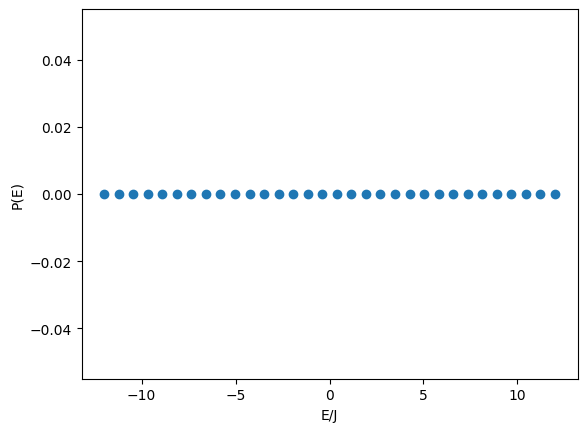

In [13]:
plt.plot(np.linspace(-0.5 / energy_norm, 0.5 / energy_norm, 2 ** n_readout), spectra[0], 'o')
plt.xlabel('E/J')
plt.ylabel('P(E)')

続いて、同じ関数を$g=0.1, 0.2, 0.3, 0.4, 0.5$について実行して、それぞれのスペクトルから系のエネルギー固有値と$g$の関係をプロットしてください。

In [14]:
for i in range(1, g_values.shape[0]):
    spectra[i] = np.roll(get_full_spectrum(g_values[i]), 2 ** (n_readout - 1))

Computed spectrum for g = 0.1 l = 0


Computed spectrum for g = 0.1 l = 1
Computed spectrum for g = 0.1 l = 2
Computed spectrum for g = 0.1 l = 3
Computed spectrum for g = 0.1 l = 4


Computed spectrum for g = 0.1 l = 5


Computed spectrum for g = 0.1 l = 6
Computed spectrum for g = 0.1 l = 7
Computed spectrum for g = 0.1 l = 8
Computed spectrum for g = 0.1 l = 9


Computed spectrum for g = 0.1 l = 10


Computed spectrum for g = 0.1 l = 11
Computed spectrum for g = 0.1 l = 12
Computed spectrum for g = 0.1 l = 13
Computed spectrum for g = 0.1 l = 14


Computed spectrum for g = 0.1 l = 15


Computed spectrum for g = 0.2 l = 0
Computed spectrum for g = 0.2 l = 1
Computed spectrum for g = 0.2 l = 2
Computed spectrum for g = 0.2 l = 3


Computed spectrum for g = 0.2 l = 4


Computed spectrum for g = 0.2 l = 5
Computed spectrum for g = 0.2 l = 6
Computed spectrum for g = 0.2 l = 7
Computed spectrum for g = 0.2 l = 8


Computed spectrum for g = 0.2 l = 9


Computed spectrum for g = 0.2 l = 10
Computed spectrum for g = 0.2 l = 11
Computed spectrum for g = 0.2 l = 12
Computed spectrum for g = 0.2 l = 13


Computed spectrum for g = 0.2 l = 14


Computed spectrum for g = 0.2 l = 15
Computed spectrum for g = 0.3 l = 0
Computed spectrum for g = 0.3 l = 1
Computed spectrum for g = 0.3 l = 2


Computed spectrum for g = 0.3 l = 3


Computed spectrum for g = 0.3 l = 4
Computed spectrum for g = 0.3 l = 5
Computed spectrum for g = 0.3 l = 6
Computed spectrum for g = 0.3 l = 7


Computed spectrum for g = 0.3 l = 8


Computed spectrum for g = 0.3 l = 9
Computed spectrum for g = 0.3 l = 10
Computed spectrum for g = 0.3 l = 11
Computed spectrum for g = 0.3 l = 12


Computed spectrum for g = 0.3 l = 13


Computed spectrum for g = 0.3 l = 14
Computed spectrum for g = 0.3 l = 15
Computed spectrum for g = 0.4 l = 0


Computed spectrum for g = 0.4 l = 1
Computed spectrum for g = 0.4 l = 2
Computed spectrum for g = 0.4 l = 3
Computed spectrum for g = 0.4 l = 4
Computed spectrum for g = 0.4 l = 5


Computed spectrum for g = 0.4 l = 6
Computed spectrum for g = 0.4 l = 7
Computed spectrum for g = 0.4 l = 8
Computed spectrum for g = 0.4 l = 9
Computed spectrum for g = 0.4 l = 10


Computed spectrum for g = 0.4 l = 11
Computed spectrum for g = 0.4 l = 12
Computed spectrum for g = 0.4 l = 13
Computed spectrum for g = 0.4 l = 14
Computed spectrum for g = 0.4 l = 15


Computed spectrum for g = 0.5 l = 0
Computed spectrum for g = 0.5 l = 1
Computed spectrum for g = 0.5 l = 2
Computed spectrum for g = 0.5 l = 3
Computed spectrum for g = 0.5 l = 4


Computed spectrum for g = 0.5 l = 5
Computed spectrum for g = 0.5 l = 6
Computed spectrum for g = 0.5 l = 7
Computed spectrum for g = 0.5 l = 8
Computed spectrum for g = 0.5 l = 9


Computed spectrum for g = 0.5 l = 10
Computed spectrum for g = 0.5 l = 11
Computed spectrum for g = 0.5 l = 12
Computed spectrum for g = 0.5 l = 13
Computed spectrum for g = 0.5 l = 14


Computed spectrum for g = 0.5 l = 15


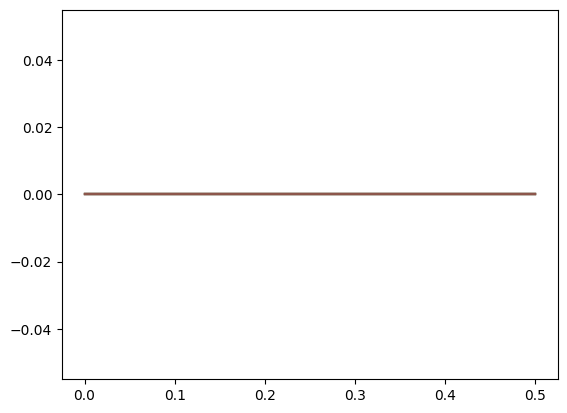

In [15]:
energy_eigenvalues = np.empty((g_values.shape[0], 2 ** n_state))

# Extract the energy eigenvalues from spectra and fill the array
##################
### EDIT BELOW ###
##################

#energy_eigenvalues[ig, m] = E_ig_m

##################
### EDIT ABOVE ###
##################

plt.plot(g_values, energy_eigenvalues)

**提出するもの**

- $P_l(k, h)$から$P(k)$を導出する方法の説明と、`get_full_spectrum`関数への実装
- $P(k)$からエネルギー固有値を抽出する方法を考案し、実装したコード（エネルギー固有値を求める全く別の方法を考えつけば、それでもよい）
- 16個のエネルギー固有値と$g$の関係のプロット

**ヒント**

（$P(k)$の導出に関して）
式{eq}`phim_decomposition`と{eq}`l_decomposition`を眺めると、

$$
\sum_{l=0}^{2^{n_S} - 1} c^l_m c^{l*}_n = \delta_{mn}
$$

が成り立つことがわかります。ここで$\delta_{mn}$はクロネッカーの$\delta$記号で、$m=n$のとき1、それ以外では0の値を持つ因子です。